# Financial Inclusion in Africa - Machine Learning Classification

This project aims to create a machine learning model to predict which individuals 
are most likely to have or use a bank account, which serves as an indicator of financial inclusion 
in Kenya, Rwanda, Tanzania, and Uganda. The goal is to understand the key factors 
that drive individuals' financial security and identify those who are financially included.

Steps Involved:
1. Data Loading and Exploration
2. Data Preprocessing
3. Model Building and Evaluation
4. Hyperparameter Tuning


In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## Step 1: Data Loading and Exploration

In [2]:
# Load the datasets
train = pd.read_csv('Train.csv')  # Training dataset
test = pd.read_csv('Test.csv')  # Test dataset
variable = pd.read_csv('VariableDefinitions.csv')  # Variable definitions
ss = pd.read_csv('SampleSubmission.csv')  # Sample submission for predictions

In [3]:
# View the first few rows of the training data
train.head(3)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed


In [4]:
# Get an overview of the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [5]:
# Check for missing values in the dataset
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [6]:
# Check the number of unique values in each column
train.nunique()

country                      4
year                         3
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
household_size              20
age_of_respondent           85
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

## Step 2: Data Visualization

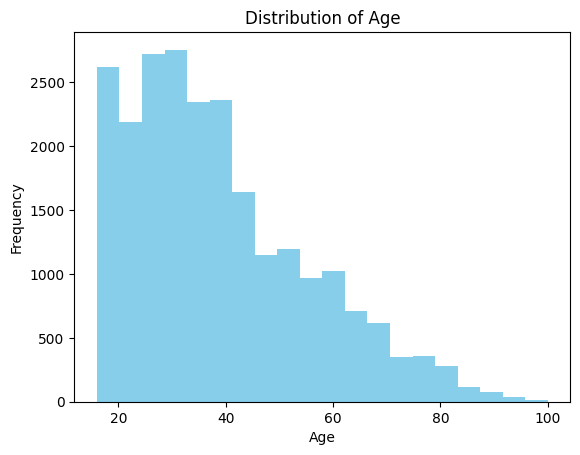

In [7]:
plt.hist(train['age_of_respondent'], bins=20, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The histogram provides a visual summary of the distribution of ages in your dataset, showing how many respondents fall into each age group.
This visualization is useful for understanding the age distribution of the respondents. 

This implies that the survey or data collection method reached more younger individuals

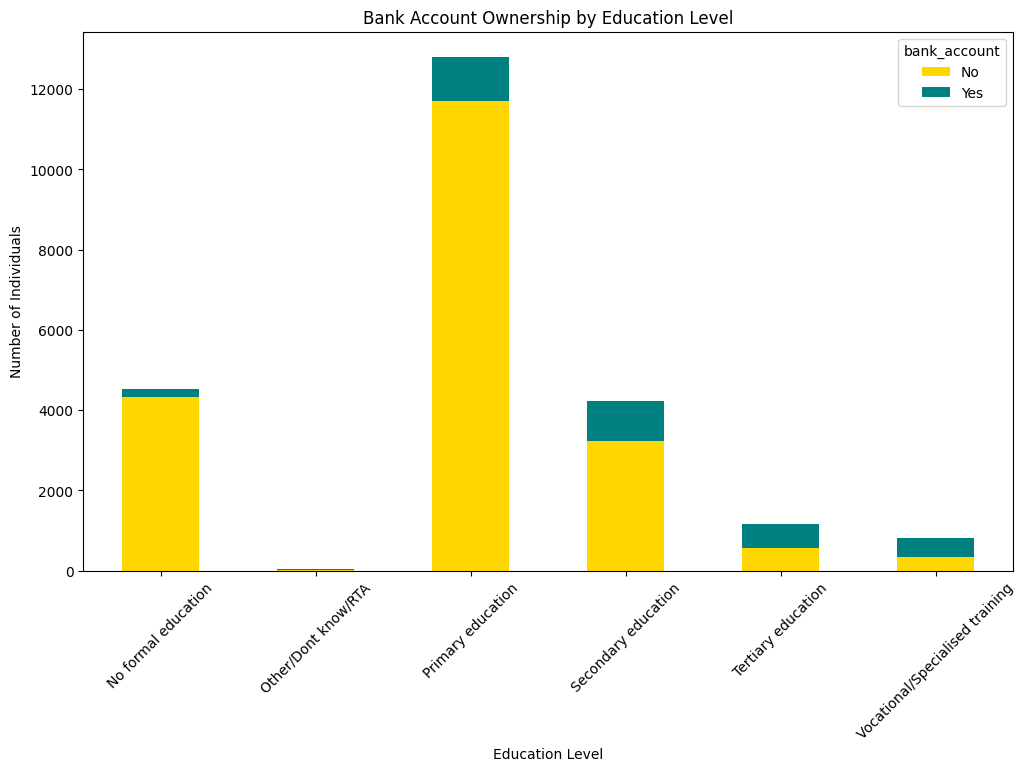

In [8]:
edu_counts = train.groupby(['education_level', 'bank_account']).size().unstack()

edu_counts.plot(kind='bar', stacked=True, figsize=(12, 7), color=['gold', 'teal'])
plt.title('Bank Account Ownership by Education Level')
plt.ylabel('Number of Individuals')
plt.xlabel('Education Level')
plt.xticks(rotation=45)
plt.show()

Display how education levels are associated with bank account ownership and we can see that most of the people with the lower education level do not have an account number.

## Step 3: Data Preprocessing

In [9]:
def preprocess_data(df, is_train=True):
    """
    Preprocess the input dataframe for machine learning models.

    This function encodes categorical variables, handles missing values, 
    and scales numerical features. It can be used for both training and test datasets.

    Parameters:
    df (pandas.DataFrame): The input dataframe to preprocess.
    is_train (bool): Flag to indicate if the dataframe is the training set. Default is True.

    Returns:
    X (pandas.DataFrame): The feature matrix after preprocessing.
    y (pandas.Series): The target variable. Only returned if is_train is True.
    """
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    import pandas as pd
    
    # Encode categorical variables using LabelEncoder
    label = LabelEncoder()
    
    if is_train:
        df['bank_account'] = label.fit_transform(df['bank_account'])
    
    df['education_level'] = label.fit_transform(df['education_level'])
    
    # Convert categorical variables to dummy/indicator variables
    df_processed = pd.get_dummies(df.drop('uniqueid', axis=1), drop_first=True).astype(int)
    
    if is_train:
        # Define features (X) and target (y)
        y = df_processed['bank_account']
        X = df_processed.drop('bank_account', axis=1)
        
        # Scale the features to have mean 0 and variance 1
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y
    
    else:
        # For the test dataset, simply return the processed features
        X_test = df_processed
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_test)
        
        return X_scaled



In [10]:
X, y = preprocess_data(train, is_train = True)

In [11]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 4: Model Building - Logistic Regression

In [12]:
# Initialize and fit the Logistic Regression model
lr = LogisticRegression()
model = lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
print(f"Logistic Regression - Accuracy: {accuracy:.4f}, Mean Absolute Error: {mae:.4f}")


Logistic Regression - Accuracy: 0.8857, Mean Absolute Error: 0.1143


## Step 5: Model Building - Random Forest

In [13]:
# Initialize and fit the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
print(f"Random Forest - Accuracy: {accuracy_score(y_pred, y_test):.4f}, Mean Absolute Error: {mean_absolute_error(y_pred, y_test):.4f}")

Random Forest - Accuracy: 0.8648, Mean Absolute Error: 0.1352


## Step 6: Model Building - Support Vector Machine (SVM)

In [14]:
# Initialize and fit the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print(f"SVM - Accuracy: {accuracy_score(y_pred, y_test):.4f}, Mean Absolute Error: {mean_absolute_error(y_pred, y_test):.4f}")

SVM - Accuracy: 0.8735, Mean Absolute Error: 0.1265


## Step 7: Model Building and Hyperparameter Tuning - XGBoost

In [16]:
# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize and set up the GridSearchCV for XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix for detailed evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the mean absolute error
print(f"XGBoost - Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\hemed\.conda\envs\Python\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Best Cross-Validation Score: 0.8888
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4063
           1       0.70      0.35      0.46       642

    accuracy                           0.89      4705
   macro avg       0.80      0.66      0.70      4705
weighted avg       0.88      0.89      0.87      4705

Confusion Matrix:
[[3967   96]
 [ 419  223]]
XGBoost - Mean Absolute Error: 0.1095


#### Observations
High True Negatives (TN): The model is very good at correctly identifying individuals who do not have a bank account (5926 out of 6073 actual negatives).
Moderate False Negatives (FN): There are 624 instances where the model fails to identify individuals who actually have a bank account. This suggests that the model is somewhat conservative and might under-predict the presence of bank accounts.
Moderate Precision and Low Recall: The precision is decent at 71.1%, meaning that when the model predicts a bank account, it is usually correct. However, the low recall of 36.6% indicates that the model misses a significant number of individuals who do have a bank account.

## Conclusion

The Model Building and Hyperparameter Tuning - XGBoost gave the best metrics (lowest mean absolute error and highest accuracy) implying that it the best model so we will use it to predict the test

## Predicting Bank account for the test data

In [ ]:
test.head(3)

In [ ]:
# Preprocessing test
processed_test = preprocess_data(test, is_train = False)

In [ ]:
# Get the predicted result for the test Data

test.bank_account = best_model.predict(processed_test)

# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

#show the five sample
submission.sample(5)

In [ ]:
# Save the submission file
submission.to_csv('first_submission.csv', index=False)

# Create a download link
from IPython.display import FileLink
FileLink('first_submission.csv')

### Steps 

#### Data Loading and Exploration 
The datasets are loaded, and the structure of the training dataset is examined. Basic data quality checks are performed, including checking for missing values and unique values in each column.

#### Visualization
A bar chart is created to visualize the distribution of the target variable (bank_account), showing how many individuals have or don't have a bank account.

#### Data Preprocessing
Categorical variables are encoded using LabelEncoder.
Dummy variables are created for categorical features.
Features and the target variable are defined.
The data is standardized using StandardScaler to prepare for model training.

#### Model Training and Evaluation
Logistic Regression: A simple logistic regression model is trained and evaluated.
Random Forest: A more complex model (Random Forest) is trained and evaluated.
Support Vector Machine (SVM): Another model (SVM with a linear kernel) is trained and evaluated.
XGBoost with Hyperparameter Tuning: XGBoost, a powerful gradient boosting model, is used with hyperparameter tuning via GridSearchCV to find the best model configuration.

#### Model Evaluation 
For each model, accuracy and mean absolute error are computed to assess performance. The best model from the grid search is further evaluated using a classification report and confusion matrix.